# MARS Algorithm
The following code is running on an Anaconda environment with Python 3.8 using Numpy 1.21.5 and Scipy 1.10.1

These specifications are required to run the py-earth contribution to scikit-learn, the package that has an implementation of the MARS algorithm.

You can find more info about the versioning and environment required to run py-earth [here](https://github.com/scikit-learn-contrib/py-earth/issues/210)

In [1]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn

from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# try:
#     from google.colab import drive
#     IN_COLAB = True

# except ImportError:
#     IN_COLAB = False
# if IN_COLAB:
#   # Check if the directory exists (change '/content/drive' to your directory)
#   drive_dir = '/content/drive'
#   drive_mounted = os.path.isdir(drive_dir)

#   # Conditionally mount the drive
#   if not drive_mounted:
#       drive.mount('/content/drive')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# sys.path.insert(0, './underlay-backlog-estimation')
import utils.network as network_class
import utils.lstm_model as lstm_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer as data_processer_functions

In [3]:

# # Define Network 1
# num_nodes = 5
# num_edges = 5

# adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
# adjacency_nodexedge = np.array([[-1,0,0,0,0], # -1 => node is edge's source
#                                 [1,-1,-1,0,0], # 1 => node is edge's destination
#                                 [0,1,0,-1,0],
#                                 [0,0,1,1,-1],
#                                 [0,0,0,0,1]])


# # Tunnel level parameters
# num_tunnels = 2

# is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
# external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
# overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
# underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# # tunnel 0
# is_edge_in_tunnel[0,:]      = np.array([1,1,0,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
# external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
# overlay_service_rates[0,:]  = np.array([1,0,0,0,0])
# underlay_service_rates[0,:] = np.array([0,1,0,1,1])

# # tunnel 1
# is_edge_in_tunnel[1,:]      = np.array([1,0,1,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
# external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])
# overlay_service_rates[1,:]  = np.array([1,0,0,0,0])
# underlay_service_rates[1,:] = np.array([0,0,1,0,1])

In [4]:
# # Define Network 2

num_nodes = 6
num_edges = 6

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1, 0, 0, 0, 0, 0], # -1 => node is edge's source
                                [ 1,-1, 0,-1, 0, 0], # 1 => node is edge's destination
                                [ 0, 1,-1, 0, 0, 0],
                                [ 0, 0, 0, 1,-1, 0],
                                [ 0, 0, 1, 0, 1,-1],
                                [ 0, 0, 0, 0, 0, 1]])


# Tunnel level parameters
num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,1,0,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[0,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[0,:] = 2*np.array([0,1,1,0,0,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,0,1,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[1,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[1,:] = 2*np.array([0,0,0,1,1,1])

In [5]:
#get network class
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel,
    underlay_service_rates,
    external_arrival_rates)


<IPython.core.display.Javascript object>


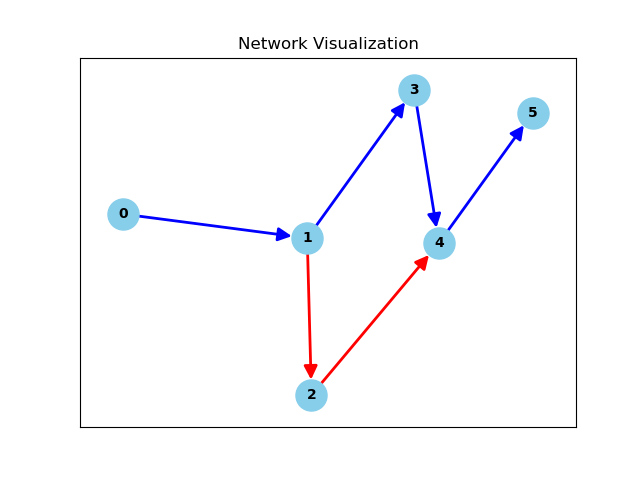

In [6]:
my_network.visualize(custom_seed = 1)


In [7]:
#simulate Network
packets_in_flight, tunnel_backlogs = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)
X,y=(packets_in_flight,tunnel_backlogs)

In [8]:
from pyearth import Earth
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
model = Earth()
model.fit(X_train, y_train)


Earth()

In [10]:
# Predict on the test set
y_pred = model.predict(X_test)


In [11]:
# Display model summary
print(model.summary())
print('RMSE: ',mean_squared_error(y_pred,y_test,squared=False))
print('MAPE: ',str(mean_absolute_percentage_error(y_test[y_test>0],y_pred[y_test>0])*100)+'%')

Earth Model
------------------------------------------------------
Basis Function  Pruned  Coefficient 0  Coefficient 1  
------------------------------------------------------
(Intercept)     No      -0.0376723     0.042418       
h(x1-130)       No      7.37229        -3.2405        
h(130-x1)       No      0.86187        0.635119       
h(x0-112)       No      0.94879        6.05723        
h(112-x0)       No      -1.00727       -0.742045      
x1              No      1.61302        1.63871        
------------------------------------------------------
MSE: 68.5191, GCV: 68.5422, RSQ: 0.8788, GRSQ: 0.8787
RMSE:  8.245824840332439
MAPE:  10.052232002320464%


<IPython.core.display.Javascript object>


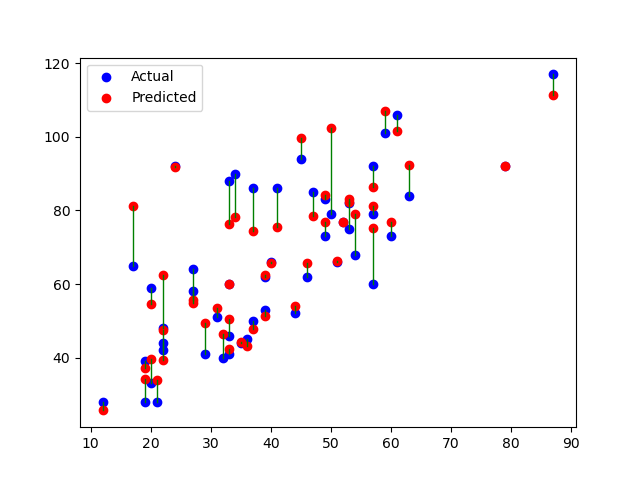

In [13]:
fig,ax=plt.subplots()
ax.scatter(X_test[:,1][1000:1050], y_test[:,1][1000:1050], color='blue', label='Actual')
ax.scatter(X_test[:,1][1000:1050], y_pred[:,1][1000:1050], color='red', label='Predicted')
ax.legend()

# Connecting points with the same x-values
for x, y1, y2 in zip(X_test[:,1][1000:1050], y_test[:,1][1000:1050], y_pred[:,1][1000:1050]):
    ax.plot([x, x], [y1, y2], color='green', linestyle='-', linewidth=1)


fig.show()